In [25]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

torch.__version__
torchtext.__version__

cpu


'0.16.2+cpu'

In [26]:
from indicnlp.tokenize import sentence_tokenize, indic_tokenize
from datasets import load_dataset, DatasetDict
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [27]:
# 1. Data Loading
# Load the full dataset
dataset = load_dataset("opus100", "en-si")
print("Original size of dataset: ", dataset)

# Reduce the training set to 10,000 samples
# Otherwise I can't finish and submit this assientment!!!
# I try to maintain the ratio of 0.2 (traning set and test set)
small_train_dataset = dataset["train"].select(range(10000))
small_test_dataset = dataset["test"].select(range(2000))
small_validation_dataset = dataset["validation"].select(range(2000))

dataset = DatasetDict({
    "train": small_train_dataset,
    "test": small_test_dataset,
    "validation": small_validation_dataset
})

# Verify the new sizes
print(dataset)

Original size of dataset:  DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 979109
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})
DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


In [28]:
# 2. Preprocessing: Tokenization and Numericalization
SRC_LANGUAGE = "en"
TRG_LANGUAGE = "si"

token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

def sinhala_tokenizer(text):
    return indic_tokenize.trivial_tokenize(text, lang='si')

token_transform[TRG_LANGUAGE] = sinhala_tokenizer

# Function to yield tokenized sentences from training data
def yield_tokens(data, language):
    for data_sample in data:
        yield token_transform[language](data_sample["translation"][language])

# Define special tokens
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# Build vocabulary from training set
vocab_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(dataset["train"], ln),
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )

# Set default index for unknown words
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

sample_si = dataset["train"][10]["translation"]["si"]
print("Raw Sinhala:", sample_si)
print("Tokenized:", sinhala_tokenizer(sample_si))

# Save vocabulary to files (ADDED THIS SECTION)
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    torch.save(vocab_transform[ln], f'vocab_{ln}.pt')
    print(f"Saved {ln} vocabulary to 'vocab_{ln}.pt'")


# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    
    for item in batch:
        src_sample = item["translation"][SRC_LANGUAGE]  # Extract English sentence
        trg_sample = item["translation"][TRG_LANGUAGE]  # Extract Sinhala sentence

        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)

    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch



# Create data loaders
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(dataset["train"], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = torch.utils.data.DataLoader(dataset["validation"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = torch.utils.data.DataLoader(dataset["test"], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
train_loader_length = len(train_loader)

Raw Sinhala: මොනවහරි ඕනද ඔයාට ?
Tokenized: ['මොනවහරි', 'ඕනද', 'ඔයාට', '?']
Saved en vocabulary to 'vocab_en.pt'
Saved si vocabulary to 'vocab_si.pt'


In [29]:
for en, en_len, si in train_loader:
    print("English shape: ", en.shape)  # (batch_size, seq_len)
    print("Sinhala shape: ", si.shape)  # (batch_size, seq_len)
    break  # Print for the first batch only

English shape:  torch.Size([32, 14])
Sinhala shape:  torch.Size([32, 17])


In [30]:
# Add  after loading data
max_src_len = max(len(x["translation"][SRC_LANGUAGE]) for x in dataset["train"])
max_trg_len = max(len(x["translation"][TRG_LANGUAGE]) for x in dataset["train"])
max_length = max(max_src_len, max_trg_len) + 10  # Add buffer

In [ ]:
# Design the model
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = AdditiveAttention(hid_dim, n_heads, dropout, device)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        # Self-attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        # Feedforward
        _src = self.feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        return src

#Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 200):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
    
# AdditiveAttention Class (Updated)
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim, n_heads=None, dropout=None, device=None):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout if dropout is not None else 0.1)
        self.device = device if device is not None else torch.device("cpu")

    def forward(self, query, key, value, mask=None):
        """
        query: [batch_size, trg_len, hid_dim]
        key: [batch_size, src_len, hid_dim]
        value: [batch_size, src_len, hid_dim]
        mask: [batch_size, 1, 1, src_len]
        """
        batch_size, trg_len, hid_dim = query.size()
        src_len = key.size(1)

        # Expand query and key for additive attention
        query_expanded = query.unsqueeze(2).expand(-1, -1, src_len, -1)  # [B, trg_len, src_len, H]
        key_expanded = key.unsqueeze(1).expand(-1, trg_len, -1, -1)       # [B, trg_len, src_len, H]

        # Calculate energy scores
        energy = torch.tanh(self.W1(key_expanded) + self.W2(query_expanded))  # [B, trg_len, src_len, H]
        attention_scores = self.V(energy).squeeze(-1)  # [B, trg_len, src_len]

        # Apply mask (if provided)
        if mask is not None:
            # Convert mask from [B, 1, 1, src_len] to [B, 1, src_len]
            mask = mask.squeeze(1)  # Remove redundant dimensions
            # Expand mask to match attention_scores dimensions
            mask = mask.expand(-1, trg_len, -1)  # [B, trg_len, src_len]
            attention_scores = attention_scores.masked_fill(mask == 0, -1e10)

        # Compute attention weights
        attention = torch.softmax(attention_scores, dim=-1)  # [B, trg_len, src_len]
        attention = self.dropout(attention)

        # Calculate context vector
        context = torch.bmm(attention, value)  # [B, trg_len, H]

        return context, attention


    
# PositionwiseFeedforwardLayer    
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x   
    
#decoder

class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = AdditiveAttention(hid_dim, None, dropout, device)
        self.encoder_attention = AdditiveAttention(hid_dim, None, dropout, device)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # Self-attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        
        # Encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        
        # Feedforward
        _trg = self.feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        return trg, attention

class Decoder(nn.Module):
    
    def __init__(self, output_dim, hid_dim, n_layers, pf_dim, dropout, device, max_length=100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([
            DecoderLayer(hid_dim, pf_dim, dropout, device) 
            for _ in range(n_layers)
        ])
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        output = self.fc_out(trg)
        return output, attention
    
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# Traning    
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
        

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 128
enc_layers = 2
dec_layers = 2
enc_heads = 4
dec_heads = 4
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              device, max_length=max_length)

dec = Decoder(
                output_dim=output_dim,
                hid_dim=hid_dim,
                n_layers=dec_layers,
                pf_dim=dec_pf_dim,
                dropout=dec_dropout,
                device=device,
                max_length=max_length  # Passed only once
)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(3179, 256)
    (pos_embedding): Embedding(329, 256)
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): AdditiveAttention(
          (W1): Linear(in_features=256, out_features=256, bias=True)
          (W2): Linear(in_features=256, out_features=256, bias=True)
          (V): Linear(in_features=256, out_features=1, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0

In [32]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

813824
 84224
   256
   256
   256
   256
 65536
   256
 65536
   256
   256
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
   256
     1
131072
   512
131072
   256
1015296
 84224
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
   256
     1
 65536
   256
 65536
   256
   256
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
   256
     1
 65536
   256
 65536
   256
   256
     1
131072
   512
131072
   256
1015296
  3966
______
4864644


In [33]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [ ]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    model.train()
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output, _ = model(src, trg[:, :-1])
        output_dim = output.shape[-1]
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        
        # Compute loss
        loss = criterion(output, trg)
        
        # Check for NaN or Inf in loss
        if math.isnan(loss.item()) or math.isinf(loss.item()):
            print("NaN or Inf detected in loss. Skipping this batch.")
            continue
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / loader_length

def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

best_valid_loss = float('inf')
num_epochs = 10
clip       = 1



train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model-additive-attentionTransformer.pt') #save_path)
    
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 3m 10s
	Train Loss: 4.757 | Train PPL: 116.410
	 Val. Loss: 4.157 |  Val. PPL:  63.868
Epoch: 02 | Time: 3m 17s
	Train Loss: 3.914 | Train PPL:  50.084
	 Val. Loss: 3.866 |  Val. PPL:  47.767
Epoch: 03 | Time: 3m 20s
	Train Loss: 3.348 | Train PPL:  28.437
	 Val. Loss: 3.778 |  Val. PPL:  43.712
Epoch: 04 | Time: 3m 28s
	Train Loss: 2.839 | Train PPL:  17.096
	 Val. Loss: 3.759 |  Val. PPL:  42.894
Epoch: 05 | Time: 3m 26s
	Train Loss: 2.372 | Train PPL:  10.715
	 Val. Loss: 3.867 |  Val. PPL:  47.802


Text(0, 0.5, 'loss')

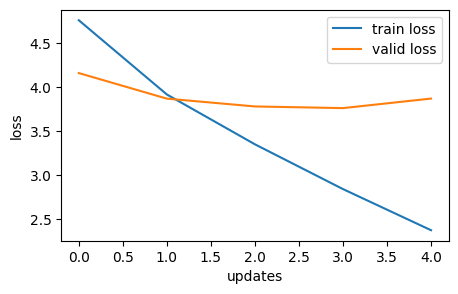

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [36]:
model.load_state_dict(torch.load('best-model-additive-attentionTransformer.pt'))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.775 | Test PPL:  43.586 |


C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_16360\4080379000.py:79: UserWarning: Glyph 3512 (\N{SINHALA LETTER MAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_16360\4080379000.py:79: UserWarning: Matplotlib currently does not support Sinhala natively.
  plt.tight_layout()
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_16360\4080379000.py:79: UserWarning: Glyph 3484 (\N{SINHALA LETTER ALPAPRAANA GAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_16360\4080379000.py:79: UserWarning: Glyph 3546 (\N{SINHALA VOWEL SIGN DIGA KOMBUVA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_16360\4080379000.py:79: UserWarning: Glyph 3520 (\N{SINHALA LETTER VAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Arunya Senadeera\AppData\Local\Temp\ipykernel_16360\40

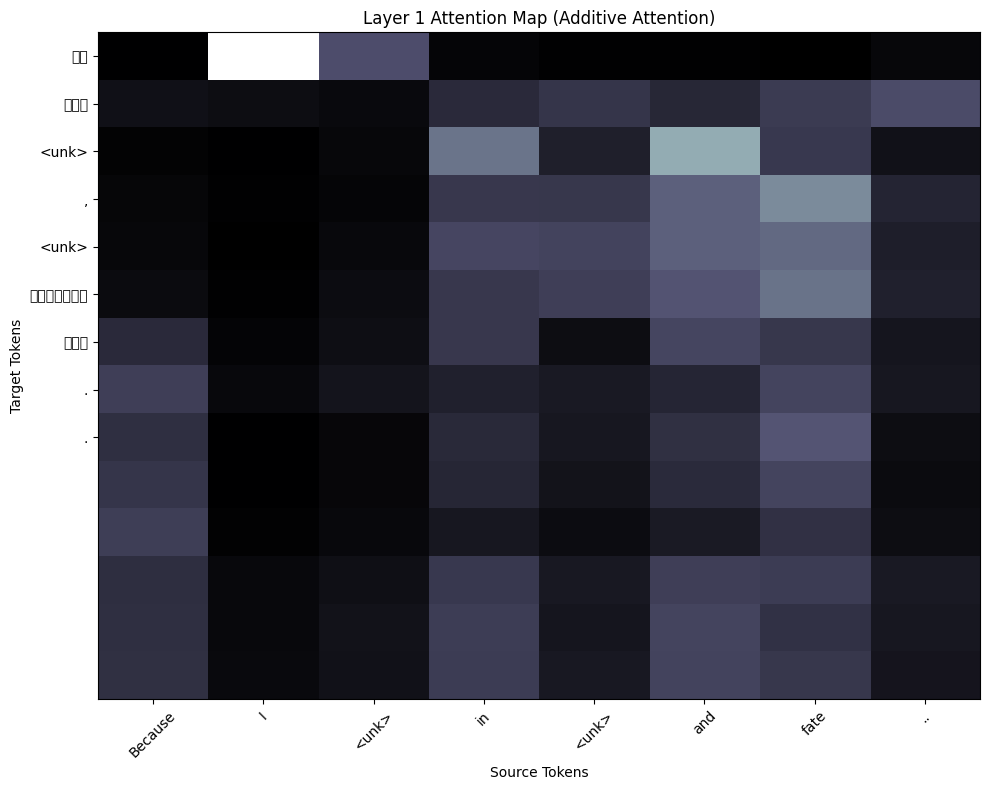

In [45]:
import matplotlib.pyplot as plt

def get_attention_layer1_head1(model, src, trg):
    attentions = []
    
    def hook(module, input, output):
        # Shape: [batch_size, trg_len, src_len] (no "num_heads" dimension)
        attentions.append(output[1].detach())  # output[1] = attention weights
    
    # Attach hook to the first decoder layer's encoder attention
    hook_handle = model.decoder.layers[0].encoder_attention.register_forward_hook(hook)
    
    with torch.no_grad():
        model(src, trg)
    
    hook_handle.remove()
    
    # Extract attention for Layer 1 (Additive Attention has no heads)
    attention = attentions[0][0]  # First batch, shape [trg_len, src_len]
    return attention 

# Function to visualize attention for Layer 1, Head 1
def visualize_attention_layer1_head1(model, data_loader, vocab_transform, src_lang, trg_lang, index=0):
    # Get a sample from the test set
    src, _, trg = next(iter(data_loader))
    src, trg = src[index:index+1].to(device), trg[index:index+1].to(device)
    
    # Ensure the target sequence has multiple tokens after excluding <eos>
    if trg.shape[1] <= 1:
        raise ValueError("Target sequence must have more than one token to visualize attention.")
    
    # Exclude <eos> from the target sequence
    trg_input = trg[:, :-1]
    
    # Ensure the target sequence has enough tokens after excluding <eos>
    if trg_input.shape[1] < 1:
        raise ValueError("Target sequence is too short after excluding <eos>.")
    
    # Get attention weights for Layer 1 (Additive Attention)
    attention = get_attention_layer1_head1(model, src, trg_input)
    
    # Convert to numpy and ensure 2D
    attention_np = attention.cpu().numpy()
    if attention_np.ndim == 1:
        attention_np = attention_np.reshape(1, -1)
    
    # Convert token IDs to words
    src_tokens = [vocab_transform[src_lang].get_itos()[i] for i in src[0].cpu().numpy()]
    trg_tokens = [vocab_transform[trg_lang].get_itos()[i] for i in trg[0].cpu().numpy()]
    
    # Clean special tokens
    src_tokens_clean = [tok for tok in src_tokens if tok not in ['<sos>', '<eos>', '<pad>']]
    trg_tokens_clean = [tok for tok in trg_tokens if tok not in ['<sos>', '<eos>', '<pad>']]
    
    # Ensure the attention map width matches the number of source tokens
    if attention_np.shape[1] != len(src_tokens_clean):
        print(f"Warning: Attention map width ({attention_np.shape[1]}) does not match source tokens ({len(src_tokens_clean)}). Adjusting...")
        # Resize the attention map to match the number of source tokens
        attention_np = attention_np[:, :len(src_tokens_clean)]
    
    # Plot the attention map
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_np, cmap='bone', aspect='auto')  # Use aspect='auto' to stretch the map
    plt.xlabel("Source Tokens")
    plt.ylabel("Target Tokens")
    plt.title("Layer 1 Attention Map (Additive Attention)")
    
    # Set x and y ticks
    plt.xticks(
        range(len(src_tokens_clean)),
        labels=src_tokens_clean,
        rotation=45
    )
    plt.yticks(
        range(len(trg_tokens_clean)),
        labels=trg_tokens_clean
    )
    
    plt.tight_layout()
    plt.show()
    
visualize_attention_layer1_head1(model, test_loader, vocab_transform, SRC_LANGUAGE, TRG_LANGUAGE, index=0)

In [42]:
import torch

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best-model-additive-attentionTransformer.pt', map_location=device))
model.to(device)
model.eval()  # Set model to evaluation mode

def translate_sentence(model, sentence, text_transform, SRC_LANGUAGE, TRG_LANGUAGE, vocab_transform, device, max_length=50):
    model.eval()
    
    # Preprocess input sentence
    src_tensor = text_transform[SRC_LANGUAGE](sentence).unsqueeze(0).to(device)  # Shape: [1, seq_len]
    
    # Create a tensor for the generated output, starting with <sos>
    trg_indexes = [SOS_IDX]
    
    with torch.no_grad():
        for _ in range(max_length):
            trg_tensor = torch.tensor(trg_indexes).unsqueeze(0).to(device)  # Shape: [1, current_seq_len]
            
            # Forward pass through the model (only src and trg)
            output, _ = model(src_tensor, trg_tensor)
            
            # Get the predicted token (last token in sequence)
            pred_token = output.argmax(2)[:, -1].item()
            
            # Append to the output sequence
            trg_indexes.append(pred_token)
            
            # Stop if <eos> token is generated
            if pred_token == EOS_IDX:
                break

    # Convert token indexes to words
    trg_tokens = [vocab_transform[TRG_LANGUAGE].get_itos()[idx] for idx in trg_indexes[1:]]  # Skip <sos>
    return " ".join(trg_tokens)

# Example Usage:
sentence = "I know it."  # Replace with any English sentence
translation = translate_sentence(model, sentence, text_transform, SRC_LANGUAGE, TRG_LANGUAGE, vocab_transform, device)
print(f"Translated Sentence: {translation}")

Translated Sentence: මම දන්නවා . <eos>
